In [81]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timedelta
from random import randrange, randint
import numpy as np
import math
from tqdm import tqdm
import csv
import random
import string
import itertools
import matplotlib.pyplot as plt

In [82]:
# Задаём число аккаунтов в сети и общее число токенов

n = 1500 
G = nx.complete_graph(n)
token_supply = 1000000000
token_distribution = {'genesis':1}


In [83]:
counter = 11

In [84]:
def random_n_digits(n):
    range_start = 10**(n-1)
    range_end = (10**n)-1
    return randint(range_start, range_end)

def generate_addresses(graph):
    for node in graph.nodes():
        graph.node[node]['address'] = 'g'+str(random_n_digits(4))+str(random.choice(string.ascii_lowercase))+\
        str(random_n_digits(4))+random.choice(string.ascii_lowercase)+str(random_n_digits(4))

In [85]:
# Распределяем роли в сети и их количество

ro = [0.25, 0.25, 0.5]

roles = {'genesis':1, 'exchange':1,
             'buyer':int(ro[0]*n), 
             'seller':int(ro[1]*n), 
             'hodler':int(n-(sum(ro[0:2]))*n)-1}


for node in G.nodes()[0:roles['genesis']]:
    G.node[node]['account_type'] = 'genesis'
for node in G.nodes()[roles['genesis']:roles['genesis']+roles['exchange']]:
    G.node[node]['account_type'] = 'exchange'
for node in G.nodes()[roles['genesis']+roles['exchange']:roles['genesis']+roles['exchange']+roles['buyer']]:
    G.node[node]['account_type'] = 'buyer'
for node in G.nodes()[roles['genesis']+roles['exchange']+roles['buyer']:
                        roles['genesis']+roles['exchange']+roles['buyer']+roles['seller']]:
    G.node[node]['account_type'] = 'seller'
for node in G.nodes()[roles['genesis']+roles['exchange']+roles['buyer']+roles['seller']:n]:
    G.node[node]['account_type'] = 'hodler'


In [86]:
# Задаём стартовую пустую историю транзакций между каждой парой пользователей

def set_initial_history(graph):
    for edge in G.edges():
        if edge[0] < edge[1]:
            G.edge[edge[0]][edge[1]]['tx_history'] = []
        

        
# Транзакция на ребре подразумевает, что первый аккаунт - отправитель, второй - получатель

def transaction(graph, edge, amount, amount_threshold, timestamp):
           
    if (graph.node[edge[0]]['balance'] >= (amount_threshold+20) ) and\
    (graph.node[edge[0]]['balance'] >= (amount+20)) and\
    (amount_threshold) <= (amount):
        
        graph.node[edge[0]]['balance'] -= (amount+20)
        graph.node[edge[1]]['balance'] += amount
        graph.node[edge[0]]['send'] += 1
        graph.node[edge[1]]['receive'] += 1
        
    
        graph.edge[edge[0]][edge[1]]['tx_history'].append({'timestamp':timestamp,'from and to':edge,'amount':amount})
            
        with open('transaction_history' + str(counter) + '.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            writer.writerow([datetime.fromtimestamp(timestamp).\
            strftime('%Y-%m-%dT%H:%M:%S'), graph.node[edge[0]]['address'], graph.node[edge[1]]['address'],\
            amount, fee])

In [87]:

'''
Второй вариант задания таймстампов - это уплотнение активности. Мы рассмотрим равномерную торговлю, экспоненциально
растущую торговлю, а также уплотнение торговли где-то посередине, задавая различные веса временным промежуткам
'''

#Делим интервал на желаемое число частей
def interval_divide(startDate, endDate, intervals):
    min = int(datetime.strptime(startDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    max = int(datetime.strptime(endDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    interval_size = round((max - min) / intervals)
    intervals_list = []
    start = min
    for start in range(min, max, interval_size):
        end = start + interval_size
        intervals_list.append([start, end])
    #print(intervals_list)
    return intervals_list

#Каждому интервалу с заданными вручную весами ставим в соответствие рандомную точку из этого интервала
def generate_weighted_activity(intervals, weights):
    weights = [w/sum(weights) for w in weights]
    tx_weighted_ts = []
    assert len(intervals) == len(weights)
    weighted_intervals = list(random.choices(intervals, weights, k=number_of_tx))
    for interval in weighted_intervals:
        tx_weighted_ts.append(random.uniform(interval[0], interval[1]))
    return tx_weighted_ts


In [88]:
def set_activity_count(graph, tx_number):
    for node in graph.nodes():
        if graph.node[node]['account_type'] == 'genesis':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
        
        if graph.node[node]['account_type'] == 'exchange':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'buyer':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'seller':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'hodler':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0

def set_start_balances(graph, token_supply):
    for node in graph.nodes():
        if graph.node[node]['account_type'] == 'genesis':
            graph.node[node]['balance'] = token_distribution['genesis']*token_supply
        else:
            graph.node[node]['balance'] = 0

In [89]:
#Проверяю число участников

exchange_count = 1
genesis_count = 1
buyer_count = 0
seller_count = 0
hodler_count = 0

for node in G.nodes():
    if G.node[node]['account_type'] == 'buyer':
        buyer_count += 1
    if G.node[node]['account_type'] == 'seller':
        seller_count += 1
    if G.node[node]['account_type'] == 'hodler':
        hodler_count += 1
        

In [90]:
# b число бизнесов, активных в сети, c список количества клиентов у каждого бизнеса, а число атакующих
def clusters(graph, b, a, c):
    assert len(c) == b
    customers = {}
    b_a = list(random.sample(range(2, n), b+a))
    businesses = b_a[0:b]
    attackers = b_a[b:len(b_a)]
    non_businesses = [n for n in G.nodes() if n not in b_a]
    i = 0
    for business in businesses:
        customers[business] = list(random.sample(non_businesses, c[0]))
        i += 1
    return businesses, customers, attackers, non_businesses

In [91]:
def form_edges(businesses, clusters, attackers):
    b_to_c_edges = []
    c_to_b_edges = []
    for business in businesses:
        for customer in clusters[business]:
            b_to_c_edges.append((business, customer))
            c_to_b_edges.append((customer, business))
    a_edges = list(itertools.combinations(attackers, 2))
    return [b_to_c_edges, c_to_b_edges], a_edges

In [92]:
def generate_cluster_activity(graph, business_edges, attack_edges, timestamps):
    b1 = random.choices(business_edges, [0.4, 0.6], k=int(0.1*number_of_tx))
    b2 = [random.choice(el) for el in b1]
    a2 = random.choices(attack_edges, k=int(0.5*number_of_tx))
    b3 = random.sample(timestamps, int(0.6*number_of_tx))
    business_ts = b3[0:int(0.1*number_of_tx)]
    attack_ts = b3[int(0.1*number_of_tx):int(0.6*number_of_tx)]
    gen = [list(i) for i in zip(b2+a2,b3)]
    return gen, business_ts, attack_ts 

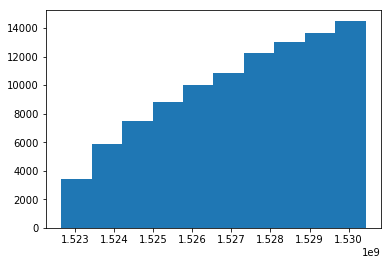

In [93]:
number_of_tx = 100000

#Задаём рост торговли в сети со временем
start = '2018-04-01 12:00:00'
end = '2018-07-01 12:00:00'
intervals = interval_divide(start, end, 100)
weights = [math.sqrt(0.75*t) for t in range(len(intervals))]

uneven_tx_ts = sorted(generate_weighted_activity(intervals, weights))

#Проверяем гистограмму числа транзакций в сети по временным интервалам
plt.hist(uneven_tx_ts)
plt.show()

In [94]:
#beta = np.random.beta(2, 9, n).tolist()
#dist = beta

In [95]:
generate_addresses(G)
set_start_balances(G, token_supply)
set_initial_history(G)

#Сумма частоток для отправлений равна 1
send = {'exchange':0.005, 'genesis':0.005, 'buyer':0.33, 'seller':0.6, 'hodler':0.06}
set_activity_count(G, number_of_tx)

In [96]:
client_list = [20, 30, 80, 20, 15, 25, 18, 10]

In [97]:
#Задаём число бизнесов и количество клиентов у каждого, клиенты могут пересекаться

businesses, groups, attackers, non_businesses = clusters(G, 8, 150, client_list)
b_edges, a_edges = form_edges(businesses, groups, attackers)
business_transactions, business_ts, attack_ts = \
generate_cluster_activity(G, b_edges, a_edges, uneven_tx_ts) 
business_transaction = sorted(business_transactions, key= lambda x: x[1])
business_ts = sorted(business_ts)
attack_ts = sorted(attack_ts)

In [98]:
#Пишем баланс генезиса в стартовый баланс
with open('balances' + str(counter) + '.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile, quoting=csv.QUOTE_NONE, escapechar=' ')
    writer.writerow([G.node[0]['address'] + ';' + str(G.node[0]['balance'])])

In [99]:
def initial_transactions(number, timestamps, fee):
    start_nodes = attackers + list(random.sample(non_businesses, k=number-len(attackers)))
    
    for i in range(number):
        
        with open('transaction_history' + str(counter) + '.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            amount = random.uniform(0.0032*token_supply,0.0033*token_supply)
            timestamp = timestamps[i]
            if G.node[0]['balance'] > (amount+20):
                G.node[0]['balance'] -= (amount+20)
                G.node[start_nodes[i]]['balance'] += amount
                G.node[0]['send'] += 1
                G.node[start_nodes[i]]['receive'] +=1
                transaction_history.append([timestamp,(0,start_nodes[i]), amount])
                writer.writerow([datetime.fromtimestamp(timestamp).\
                strftime('%Y-%m-%dT%H:%M:%S'), G.node[0]['address'], G.node[start_nodes[i]]['address'],\
                amount, fee])
    

In [100]:
#Сумма равна единице
receive = {'exchange':0.05, 'genesis':0, 'buyer':0.55, 'seller':0.25, 'hodler':0.15}

node_receiver_weights = []
node_sender_weights = []

for node in G.nodes():
    if G.node[node]['account_type'] == 'genesis':
        node_sender_weights.append(send['genesis']/genesis_count)
        node_receiver_weights.append(receive['genesis']/genesis_count)
    if G.node[node]['account_type'] == 'exchange':
        node_sender_weights.append(send['exchange']/exchange_count)
        node_receiver_weights.append(receive['exchange']/exchange_count)
    if G.node[node]['account_type'] == 'buyer':
        node_sender_weights.append(send['buyer']/buyer_count)
        node_receiver_weights.append(receive['buyer']/buyer_count)
    if G.node[node]['account_type'] == 'seller':
        node_sender_weights.append(send['seller']/seller_count)
        node_receiver_weights.append(receive['seller']/seller_count)
    if G.node[node]['account_type'] == 'hodler':
        node_sender_weights.append(send['hodler']/hodler_count)
        node_receiver_weights.append(receive['hodler']/hodler_count)

        
#Нормируем веса так, чтобы их сумма равнялась [приблизительно] единице
norm_sender_weights = [float(i)/sum(node_sender_weights) for i in node_sender_weights]
norm_receiver_weights = [float(i)/sum(node_receiver_weights) for i in node_receiver_weights]


#Выбираем k отправителей и получателей с заданными весами, которые определяют их частоту появления в транзакции
send_list = list(random.choices(G.nodes(), norm_sender_weights, k=number_of_tx*2))
receive_list = list(random.choices(G.nodes(), norm_receiver_weights, k=number_of_tx*2))

#Формируем пары отправитель и получатель, удаляем пары, где они совпали
network_edges = [t for t in list(zip(send_list, receive_list)) if (t[0] != t[1]) and\
                (t[0] not in attackers) and (t[1]) not in attackers and\
                (t[0] not in businesses) and (t[1] not in businesses)]


In [101]:
bc_edges = random.choices(b_edges[0]+b_edges[1], k=int(0.1*number_of_tx))
att_edges = random.choices(a_edges, k=int(0.5*number_of_tx))

In [102]:
tuple(random.sample([5, 7, 8, 19], 2))

(7, 8)

In [103]:
#Запускаем торговлю между пользователями

amount_threshold = 1000
fee = 20
transaction_history = []
initial_transactions(300, uneven_tx_ts[0:300], fee)

b = 0
a = 0
e = 0
for t in tqdm(uneven_tx_ts):
    
    if t in business_ts:
        
        b_edge = bc_edges[b]
        if G.node[b_edge[0]]['balance'] > amount_threshold + fee:
            amount = random.uniform(amount_threshold + fee, 0.4*G.node[b_edge[0]]['balance'])
        else:
            amount = 0
        
        if (amount_threshold + fee > G.node[b_edge[0]]['balance']) or (amount + fee > G.node[b_edge[0]]['balance']):
            pass
        else:
            transaction(G, b_edge, amount, amount_threshold, t)
            transaction_history.append([t, b_edge, amount])
        b += 1
            
    elif t in attack_ts:
        
        rich_attackers = sorted([a for a in attackers], key=lambda x: G.node[x]['balance'])[::-1]
        a_edge = tuple(random.sample(rich_attackers[0:10], 2))
        if G.node[a_edge[0]]['balance'] > amount_threshold + fee:
            amount = random.uniform(0.8*G.node[a_edge[0]]['balance'], 0.9*G.node[a_edge[0]]['balance'])
        else:
            amount = 0
        
        if (amount_threshold + fee > G.node[a_edge[0]]['balance']) or (amount + fee > G.node[a_edge[0]]['balance']):
            pass
        else:
            transaction(G, a_edge, amount, amount_threshold, t)
            transaction_history.append([t, a_edge, amount])
        a += 1
      
    
    else:
        
        e_edge = network_edges[e]
        if G.node[e_edge[0]]['balance'] > amount_threshold + fee:
            amount = random.uniform(amount_threshold + fee, 0.3*G.node[e_edge[0]]['balance'])
        else: 
            amount = 0
        
        if (amount_threshold + fee > G.node[e_edge[0]]['balance']) or (amount + fee > G.node[e_edge[0]]['balance']):
            pass
        else:
            transaction(G, e_edge, amount, amount_threshold, t)
            transaction_history.append([t, e_edge, amount])
        e += 1
    
    

100%|██████████| 100000/100000 [04:52<00:00, 341.92it/s]


In [104]:
print('Start:', start)
print('End:', end)
print('Accounts:', n)
print('Transactions:', number_of_tx)
print('Token sypply:', token_supply)
print('Token distribution:', token_distribution)
print('Roles:', roles)
print('Sender and receiver weights:')
print(send)
print(receive)
print('Transaction fee:', 20)
print('Attackers:', len(attackers))
print('Businesses:', len(businesses))
print('Client number:', client_list)
print('Attackers')
for node in attackers:
    print(G.node[node]['address'])
print('Businesses')
for node in businesses:
    print(G.node[node]['address'])
print('Attack, business and regular transactions:')
print(b, a, e)

Start: 2018-04-01 12:00:00
End: 2018-07-01 12:00:00
Accounts: 1500
Transactions: 100000
Token sypply: 1000000000
Token distribution: {'genesis': 1}
Roles: {'genesis': 1, 'exchange': 1, 'buyer': 375, 'seller': 375, 'hodler': 749}
Sender and receiver weights:
{'exchange': 0.005, 'genesis': 0.005, 'buyer': 0.33, 'seller': 0.6, 'hodler': 0.06}
{'exchange': 0.05, 'genesis': 0, 'buyer': 0.55, 'seller': 0.25, 'hodler': 0.15}
Transaction fee: 20
Attackers: 150
Businesses: 8
Client number: [20, 30, 80, 20, 15, 25, 18, 10]
Attackers
g6179m4151j2811
g7310y9232g2909
g8983n2757c4203
g1948e9519k7858
g7987g4709w9918
g6509k4727s6127
g9650c5595a8464
g8733d1162m1890
g5973s2134h7012
g3122v7070g7621
g7926j8929y2354
g2725m2446e8329
g5617k6819i8271
g2058r1856x1385
g8025j1854u7310
g4439f4431d6571
g7643r3594e2244
g9579h5944t4796
g6995e8760u3757
g5672p9509s2496
g4965t3061z5050
g6632j4394m2516
g9847q7584q9670
g2957i8069q9368
g3666v6966g9208
g7018s6685b1031
g8200n8837u6486
g1471t3860o6885
g8235q3564c9086
g6407f9

In [105]:
interval_volumes = []
for interval in intervals:
    interval_volumes.append(0)
    for event in transaction_history:
        if event[0] >= interval[0] and event[0] < interval[1]:
            interval_volumes[-1] += event[2]

In [106]:
len(interval_volumes)

100

In [107]:
interval_count = []
for interval in intervals:
    interval_count.append(0)
    for event in transaction_history:
        if event[0] >= interval[0] and event[0] < interval[1]:
            interval_count[-1] += 1

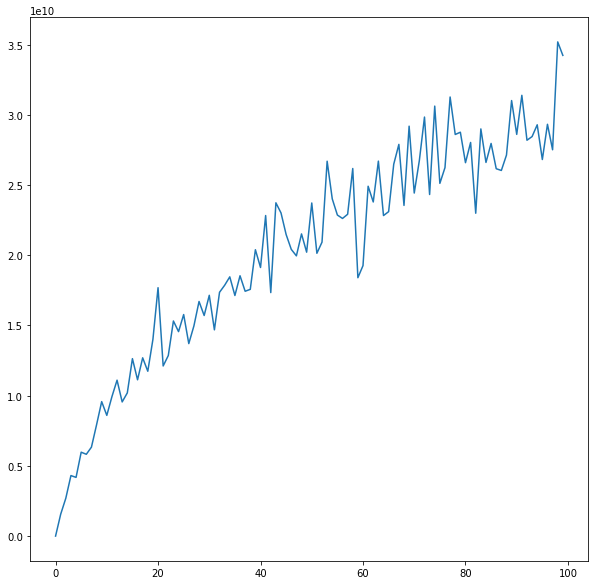

In [108]:
plt.plot(interval_volumes)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

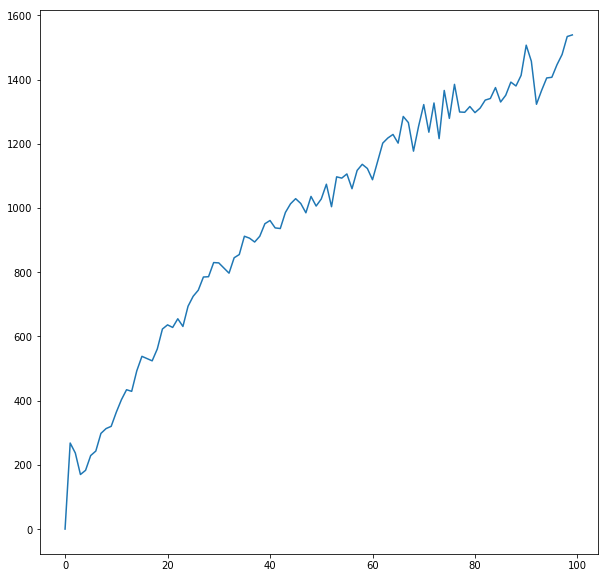

In [109]:
plt.plot(interval_count)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [110]:
for node in G.nodes():
    print(G.node[node])

{'account_type': 'genesis', 'address': 'g2834v5381r7956', 'balance': 785.10211705355, 'send': 350, 'receive': 0}
{'account_type': 'exchange', 'address': 'g5704s5763j9165', 'balance': 4578227.086715381, 'send': 194, 'receive': 2067}
{'account_type': 'buyer', 'address': 'g5515s5073b1274', 'balance': 250148.8427876762, 'send': 40, 'receive': 57}
{'account_type': 'buyer', 'address': 'g6012l6386n9501', 'balance': 633464.3111485578, 'send': 80, 'receive': 115}
{'account_type': 'buyer', 'address': 'g1767s5140l5555', 'balance': 370966.00795540144, 'send': 30, 'receive': 68}
{'account_type': 'buyer', 'address': 'g6504g8522m4832', 'balance': 309084.8374881433, 'send': 34, 'receive': 73}
{'account_type': 'buyer', 'address': 'g1808z7355i8363', 'balance': 193163.99444311467, 'send': 35, 'receive': 64}
{'account_type': 'buyer', 'address': 'g1526v3842c2482', 'balance': 219020.6270808479, 'send': 86, 'receive': 85}
{'account_type': 'buyer', 'address': 'g5405l3384t3154', 'balance': 147.15709290221594, 

{'account_type': 'seller', 'address': 'g9118h2733b4920', 'balance': 288667.7029356302, 'send': 88, 'receive': 63}
{'account_type': 'seller', 'address': 'g3685q6381p7997', 'balance': 189153.7651016368, 'send': 47, 'receive': 31}
{'account_type': 'seller', 'address': 'g1470m9921s1432', 'balance': 17225.28703109187, 'send': 76, 'receive': 27}
{'account_type': 'seller', 'address': 'g4681u1205o4660', 'balance': 79243.01404750923, 'send': 70, 'receive': 26}
{'account_type': 'seller', 'address': 'g1681v1251p3248', 'balance': 167779.47505346517, 'send': 59, 'receive': 20}
{'account_type': 'seller', 'address': 'g5265m5812b8758', 'balance': 112922.31445586414, 'send': 68, 'receive': 34}
{'account_type': 'seller', 'address': 'g5053z4061o3210', 'balance': 19290.48193465266, 'send': 55, 'receive': 23}
{'account_type': 'seller', 'address': 'g3037h1651z6023', 'balance': 35920.17782421285, 'send': 70, 'receive': 28}
{'account_type': 'seller', 'address': 'g4967c2725o2179', 'balance': 81687.64856014035,

In [111]:
for a in att_edges:
    print(G.edge[a[0]][a[1]])

{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1523845641.301154, 'from and to': (880, 1028), 'amount': 1651484.4010807723}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1528485773.4578562, 'from and to': (1012, 912), 'amount': 45026592.05396124}, {'timestamp': 1528488803.3147473, 'from and to': (912, 1012), 'amount': 77663909.61610027}, {'timestamp': 1528496273.1765053, 'from and to': (912, 1012), 'amount': 4367.866537185464}, {'timestamp': 1528497672.628415, 'from and to': (912, 1012), 'amount': 45358337.61448038}, {'timestamp': 1528503025.8053503, 'from and to': (1012, 912), 'amount': 1487827.223957095}, {'timestamp': 1528505139.0781486, 'from and to': (912, 1012), 'amount': 29375305.96126238}, {'timestamp': 1528507266.8754337, 'from and to': (1012, 912), 'amount': 3696115.586015115}, {'timestamp': 1528521667.3971455, 'from and to': (1012, 912), 'amount': 7105127.

{'tx_history': [{'timestamp': 1528910705.3064153, 'from and to': (135, 311), 'amount': 25601754.149568316}, {'timestamp': 1528911413.1181893, 'from and to': (135, 311), 'amount': 43269.978457946585}, {'timestamp': 1528911868.7731574, 'from and to': (311, 135), 'amount': 874717.5042282322}, {'timestamp': 1528912106.2668774, 'from and to': (135, 311), 'amount': 770986.7580288134}, {'timestamp': 1528919874.2786264, 'from and to': (311, 135), 'amount': 1343165.6792025208}, {'timestamp': 1528925412.7072797, 'from and to': (135, 311), 'amount': 32995415.32001666}, {'timestamp': 1528930279.3310363, 'from and to': (135, 311), 'amount': 1230455.2728563386}, {'timestamp': 1528933396.115705, 'from and to': (135, 311), 'amount': 89961022.81528755}, {'timestamp': 1528938758.9665015, 'from and to': (311, 135), 'amount': 37894661.97764103}, {'timestamp': 1528945582.6335285, 'from and to': (311, 135), 'amount': 198972586.36626974}, {'timestamp': 1528952793.6142802, 'from and to': (135, 311), 'amount':

{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1523096497.695344, 'from and to': (1444, 1405), 'amount': 118710.26956497155}]}
{'tx_history': []}
{'tx_history': [{'timestamp': 1525672388.3974237, 'from and to': (271, 1323), 'amount': 4083873.2586570666}, {'timestamp': 1525674454.5710137, 'from and to': (271, 1323), 'amount': 944845.4525324391}, {'timestamp': 1525674973.3218987, 'from and to': (271, 1323), 'amount': 36101966.620776474}, {'timestamp': 1525676751.5868464, 'from and to': (271, 1323), 'amount': 79780.86268503644}, {'timestamp': 1525680148.2379024, 'from and to': (271, 1323), 'amount': 200611305.35778064}, {'timestamp': 1525682012.234326, 'from and to': (1323, 271), 'amount': 186457074.3680761}, {'timestamp': 1525683026.1426337, 'from and to': (1323, 271), 'amount': 18321614.898411065}, {'timestamp': 1525694467.5194688, 'from and to': (271, 1323), 'amount': 387167.6116141066}, {'timestamp': 1525698

{'tx_history': []}
{'tx_history': [{'timestamp': 1523848394.0651405, 'from and to': (938, 1287), 'amount': 17232932.639552016}, {'timestamp': 1523869404.6173086, 'from and to': (1287, 938), 'amount': 47835498.01087733}, {'timestamp': 1523889661.50231, 'from and to': (1287, 938), 'amount': 374517.13619140664}, {'timestamp': 1523892542.0215933, 'from and to': (1287, 938), 'amount': 250344300.97106305}, {'timestamp': 1523893892.0576613, 'from and to': (1287, 938), 'amount': 6741390.104756581}, {'timestamp': 1523944671.8123887, 'from and to': (1287, 938), 'amount': 2258907.6458150917}, {'timestamp': 1523947444.238554, 'from and to': (1287, 938), 'amount': 36668.86033571766}, {'timestamp': 1523948178.7815347, 'from and to': (938, 1287), 'amount': 1647160.8164627862}, {'timestamp': 1526223819.769055, 'from and to': (938, 1287), 'amount': 13012408.34439583}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'tim

{'tx_history': [{'timestamp': 1526366532.8103883, 'from and to': (1270, 985), 'amount': 201569894.75054693}, {'timestamp': 1526421748.3939583, 'from and to': (985, 1270), 'amount': 6848709.222923988}, {'timestamp': 1526429616.9486682, 'from and to': (985, 1270), 'amount': 7700360.276705081}, {'timestamp': 1526430148.6297827, 'from and to': (1270, 985), 'amount': 36853667.18687172}, {'timestamp': 1526434675.3257887, 'from and to': (1270, 985), 'amount': 60067791.40450444}, {'timestamp': 1526437382.7924619, 'from and to': (985, 1270), 'amount': 52513213.99851079}, {'timestamp': 1526440698.2588396, 'from and to': (1270, 985), 'amount': 141110041.4281622}, {'timestamp': 1526446785.3174877, 'from and to': (1270, 985), 'amount': 360634.6858811738}, {'timestamp': 1526447447.414315, 'from and to': (1270, 985), 'amount': 45168.58739467505}, {'timestamp': 1526464413.003078, 'from and to': (1270, 985), 'amount': 5012181.227121605}, {'timestamp': 1526468738.7254496, 'from and to': (985, 1270), 'am

{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1524500675.102015, 'from and to': (830, 217), 'amount': 38531133.19855161}, {'timestamp': 1524511573.6393025, 'from and to': (830, 217), 'amount': 1062509.4591838624}, {'timestamp': 1524515942.7598667, 'from and to': (830, 217), 'amount': 658147.0155364918}, {'timestamp': 1524524681.6124048, 'from and to': (830, 217), 'amount': 88748885.26063667}, {'timestamp': 1524544758.7807202, 'from and to': (217, 830), 'amount': 812297.5650723228}, {'timestamp': 1524545601.8289626, 'from and to': (830, 217), 'amount': 882197.8910339191}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1522979329.019576, 'from and to': (1209, 790), 'amount': 356703.23973865085}, {'timestamp': 1524798495.7425375, 'from and to': (790, 1209), 'amount': 110462.62506576543}, {'timestamp': 1524798698.9474926, 'from and to': (1209, 790), 'amount': 156244011.3446523}, {'timestamp': 1524802785.1859603, 'from and to': (790, 1209), 'amoun

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1522985745.3791726, 'from and to': (188, 191), 'amount': 13020742.096505735}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1525012749.3168025, 'from and to': (972, 965), 'amount': 1810351.4887680975}, {'timestamp': 1525022564.6675847, 'from and to': (965, 972), 'amount': 7500194.914361051}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1524632878.3762953, 'from and to': (977, 559), 'amount': 1033390.093252136}, {'timestamp': 1524634129.5382454, 'from and to': (559, 977), 'amount': 140700.62611587704}, {'timestamp': 1524641705.706355, 'from and to': (559, 977), 'amount': 28139219.230659436}, {'timestamp': 1524643147.2798078, 'from and to': (977, 559), 'amount': 4129877.4305058904}, {'timestamp': 1524644427.3236408, 'from and to': (559, 977), 'amount': 9233487.59287369}, {'timestamp': 1524655503.5739284, 'from and to'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



{'tx_history': [{'timestamp': 1523294503.3837726, 'from and to': (901, 899), 'amount': 879813.9146131205}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1529213216.6738539, 'from and to': (1097, 1365), 'amount': 54935775.60607815}, {'timestamp': 1529215092.6244483, 'from and to': (1097, 1365), 'amount': 2939210.976550964}, {'timestamp': 1529217786.4982798, 'from and to': (1365, 1097), 'amount': 15161337.738786599}, {'timestamp': 1529219048.0465949, 'from and to': (1097, 1365), 'amount': 2399730.092136058}, {'timestamp': 1529226864.9462738, 'from and to': (1097, 1365), 'amount': 20939243.45813232}, {'timestamp': 1529228134.8456273, 'from and to': (1365, 1097), 'amount': 76721272.37184258}, {'timestamp': 1529239270.9881842, 'from and to': (1365, 1097), 'amount': 106184975.47144699}, {'timestamp': 1529240712.6626234, 'from and to': (1097, 1365), 'amount': 53190101.96359018}, {'timestamp': 1529241367.9770799, 'from and to': (1365, 1097), 'amount': 82031501.33084875}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


{'tx_history': [{'timestamp': 1526145558.3899212, 'from and to': (117, 705), 'amount': 6437.598436795817}, {'timestamp': 1526146323.891985, 'from and to': (117, 705), 'amount': 1111.3993112316164}]}
{'tx_history': [{'timestamp': 1523823015.1732101, 'from and to': (192, 188), 'amount': 3064.0523036053823}, {'timestamp': 1526484634.2982416, 'from and to': (192, 188), 'amount': 41023540.04493406}, {'timestamp': 1526492765.9341893, 'from and to': (192, 188), 'amount': 305616900.1901983}, {'timestamp': 1526493927.1867192, 'from and to': (192, 188), 'amount': 53600253.882749185}, {'timestamp': 1526506060.5619724, 'from and to': (188, 192), 'amount': 201991683.13727716}, {'timestamp': 1526506261.87929, 'from and to': (192, 188), 'amount': 174862154.71124178}, {'timestamp': 1526510464.9453566, 'from and to': (188, 192), 'amount': 4679929.712986871}, {'timestamp': 1526510950.712086, 'from and to': (188, 192), 'amount': 532607.0645641013}, {'timestamp': 1526512489.7268267, 'from and to': (188, 1

{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1527109939.8256407, 'from and to': (707, 521), 'amount': 30256656.672281783}, {'timestamp': 1527113530.4490469, 'from and to': (521, 707), 'amount': 5146244.295771785}, {'timestamp': 1527114008.389094, 'from and to': (521, 707), 'amount': 92185.83989963646}, {'timestamp': 1527114439.256705, 'from and to': (707, 521), 'amount': 5066893.593691505}, {'timestamp': 1527116702.0811584, 'from and to': (707, 521), 'amount': 118406879.66542444}, {'timestamp': 1527118713.5967174, 'from and to': (707, 521), 'amount': 21863404.678404886}, {'timestamp': 1527131668.783302, 'from and to': (521, 707), 'amount': 23174279.65028161}, {'timestamp': 1527136036.08113, 'from and to': (707, 521), 'amount': 23387181.09999061}, {'timestamp': 1527144687.4641635, 'from and to': (707, 521), 'amount': 1657272.3240389086}, {'timestamp': 1527145363.0628924, 'from and to': (521, 707), 'amount': 1544616.5318555923}

{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1524540255.6011236, 'from and to': (1300, 326), 'amount': 36622109.60883178}, {'timestamp': 1524540347.0184, 'from and to': (326, 1300), 'amount': 258373217.21689624}, {'timestamp': 1524550380.3380258, 'from and to': (326, 1300), 'amount': 45558244.398870446}, {'timestamp': 1524563972.2765205, 'from and to': (1300, 326), 'amount': 8300809.318439128}, {'timestamp': 1525310960.0142927, 'from and to': (1300, 326), 'amount': 629501.2819920026}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1522673126.3779547, 'from and to': (320, 307), 'amount': 24336728.032009866}, {'timestamp': 1522673764.466953, 'from and to': (307, 320), 'amount': 22368148.945336543}, {'timestamp': 1522696376.1019325, 'from and to': (307, 320), 'amount': 3173847.621175996}]}
{'tx_history': []}
{'tx_history': [{'timestamp': 1526543100.06

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



{'tx_history': []}
{'tx_history': [{'timestamp': 1524058194.8638928, 'from and to': (261, 965), 'amount': 8545134.362319402}, {'timestamp': 1524061899.7878597, 'from and to': (261, 965), 'amount': 16670.41013028061}, {'timestamp': 1524073441.5411823, 'from and to': (965, 261), 'amount': 66543794.054602325}, {'timestamp': 1524088603.3360145, 'from and to': (261, 965), 'amount': 260371.42978716904}, {'timestamp': 1524089267.0566716, 'from and to': (261, 965), 'amount': 50850.826875525454}]}
{'tx_history': [{'timestamp': 1524510883.4716902, 'from and to': (1122, 1365), 'amount': 4620132.034474759}]}
{'tx_history': []}
{'tx_history': [{'timestamp': 1524866803.0418806, 'from and to': (828, 1356), 'amount': 252551.36783838968}, {'timestamp': 1524877503.3060417, 'from and to': (828, 1356), 'amount': 12080592.046256993}, {'timestamp': 1524884107.868042, 'from and to': (1356, 828), 'amount': 12152415.938288555}, {'timestamp': 1524891563.5751953, 'from and to': (828, 1356), 'amount': 259559.103

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



{'tx_history': []}
{'tx_history': [{'timestamp': 1528188919.2543287, 'from and to': (440, 1207), 'amount': 9103146.699513515}, {'timestamp': 1528194294.002426, 'from and to': (1207, 440), 'amount': 15779834.665101673}, {'timestamp': 1528195419.5294597, 'from and to': (440, 1207), 'amount': 33672.42563533439}, {'timestamp': 1528196501.69424, 'from and to': (440, 1207), 'amount': 2273108.4861925617}, {'timestamp': 1528196798.2509673, 'from and to': (440, 1207), 'amount': 337582.9405804453}, {'timestamp': 1528197809.2246583, 'from and to': (440, 1207), 'amount': 43379.35818769365}, {'timestamp': 1528204468.4267607, 'from and to': (440, 1207), 'amount': 5817563.293585111}, {'timestamp': 1528207848.7310805, 'from and to': (440, 1207), 'amount': 1995519.1996181805}, {'timestamp': 1528243853.0468845, 'from and to': (1207, 440), 'amount': 20888895.491358157}, {'timestamp': 1528246889.4670215, 'from and to': (440, 1207), 'amount': 21413027.53520716}, {'timestamp': 1528259170.7515962, 'from and

{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1523036914.1353862, 'from and to': (215, 1000), 'amount': 182808.48224512956}]}
{'tx_history': [{'timestamp': 1523604570.7244432, 'from and to': (72, 1171), 'amount': 137536.85823485669}]}
{'tx_history': []}
{'tx_history': [{'timestamp': 1525519112.8929276, 'from and to': (1271, 440), 'amount': 1429334.0808409075}, {'timestamp': 1525530486.5115342, 'from and to': (1271, 440), 'amount': 72905693.91448501}, {'timestamp': 1525533330.9843576, 'from and to': (1271, 440), 'amount': 259433624.05952203}, {'timestamp': 1525536007.662243, 'from and to': (1271, 440), 'amount': 8358015.589450043}, {'timestamp': 1525538502.2064188, 'from and to': (440, 1271), 'amount': 962865.4945226607}, {'timestamp': 1525546939.492021, 'from and to': (440, 1271), 'amount': 27723197.942046624}, {'timestamp': 1525563592.7713597, 'from and to': (440, 1271), 'amount': 1514574.342197819}, {'timestamp': 1525570647.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1523513327.1733866, 'from and to': (306, 326), 'amount': 11790.80741611405}]}
{'tx_history': []}
{'tx_history': []}
{'tx_history': []}
{'tx_history': [{'timestamp': 1529022234.072886, 'from and to': (135, 213), 'amount': 27898632.797954574}, {'timestamp': 1529024552.9912677, 'from and to': (135, 213), 'amount': 711174.4428776071}, {'timestamp': 1529032470.7069955, 'from and to': (213, 135), 'amount': 7464130.275881631}, {'timestamp': 1529035075.3584077, 'from and to': (213, 135), 'amount': 40408.50727513057}, {'timestamp': 1529039972.0318587, 'from and to': (213, 135), 'amount': 36246863.91947526}, {'timestamp': 1529058879.8884852, 'from and to': (213, 135), 'amount': 2166885.3707417054}, {'timestamp': 1529075302.3270314, 'from and to': (213, 135), 'amount': 6056546.253219956}, {'timestamp': 1529082732.7905777, 'from and to': (135, 213), 'amount': 3406115.925505112}, {'timestamp': 1529100647.116967, 'from and to': (13

In [112]:
c = 0
for edge in G.edges():
    if G.edge[edge[0]][edge[1]]['tx_history'] != [] and len(G.edge[edge[0]][edge[1]]['tx_history']) > 1:
        #print(len(G.edge[edge[0]][edge[1]]['tx_history']))
        #print(G.edge[edge[0]][edge[1]]['tx_history'])
        c += 1
#print(c)

In [113]:
'''
for node in G.nodes():
    if G.node[node]['address'] == 'g5065b7204b5364':
        print(node, G.node[node])

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-113-1d25cc867c78>, line 4)

In [ ]:
'''
for edge in G.edges():
    if 782 in edge:
        if G.edge[edge[0]][edge[1]]['tx_history'] != []:
            for h in G.edge[edge[0]][edge[1]]['tx_history']:
                print(h['amount'])

In [ ]:
'''
ff = 55563.6762078773
l = 0
sent = 0
received = 0



for edge in G.edges():
    if 782 in edge:
        for h in G.edge[edge[0]][edge[1]]['tx_history']:
            if h['from and to'][0] == 782:
                #print('748 sender')
                ff -= (h['amount']+20)
                sent += (h['amount']+20)
                
            if h['from and to'][1] == 782:
                #print('748 receiver')
                ff += h['amount']
                received += h['amount']
                

In [ ]:
'''
print(55563.6762078773)
print(sent)
print(received)
print(ff)

In [ ]:
'''
for edge in G.edges():
    if G.edge[edge[0]][edge[1]]['tx_history'] != []:
        pass
        #print(G.edge[edge[0]][edge[1]])

In [ ]:
'''
for node in G.nodes():
    if G.node[node]['address'] == 'g4490t9883q1674':
        print(node, G.node[node])